In [1]:
import pandas as pd
from pandas.errors import EmptyDataError
import matplotlib.pyplot as plt
import numpy as np

import glob
import os

#experiment = "../results/0/splitwise_27_13/rr_conv_80/40_0/bloom-176b/mixed_pool/"
#experiment = "../results/0/splitwise_27_13/rr_conv_30/40_0/bloom-176b/mixed_pool/" 
#experiment = "../results/0/splitwise_27_13/rr_conv_250/40_0/bloom-176b/mixed_pool/" 
#experiment = "../results/0/splitwise_1_1/rr_conv_30/26_25/bloom-176b/mixed_pool/" 
#experiment = "../results/0/splitwise_1_1/rr_conv_100/26_25/bloom-176b/mixed_pool/" 
experiment = "../results/0/splitwise_1_1/rr_conv_250/26_25/bloom-176b/mixed_pool/" 

# Original data file path
data = experiment + "cpu_usage/cpu_usage_0.csv"

# Get the directory of the data file
directory = os.path.dirname(data)

# Create a pattern to match all cpu_usage_*.csv files in the directory
pattern = os.path.join(directory, 'cpu_usage_*.csv')

# Use glob to get all filenames matching the pattern
file_list = glob.glob(pattern)


# Function to extract machine_id from filename
def extract_machine_id(file):
    basename = os.path.basename(file)  # Get the filename with extension
    name, _ = os.path.splitext(basename)  # Remove the extension
    parts = name.split('_')  # Split the name by underscores
    machine_id = parts[-1]  # Get the last part as machine_id
    return machine_id

# Read all CSV files, add 'machine id' column, and concatenate them into a single DataFrame
df_list = []
for file in file_list:
    try:
        df_temp = pd.read_csv(file)  # Read the CSV file
    except EmptyDataError:
        print(file, "is empty or has no columns to parse... skipping")
        continue
    df_temp['machine id'] = extract_machine_id(file)  # Add the 'machine id' column
    df_list.append(df_temp)  # Add to the list of DataFrames

# Concatenate all DataFrames into one
df = pd.concat(df_list, ignore_index=True)

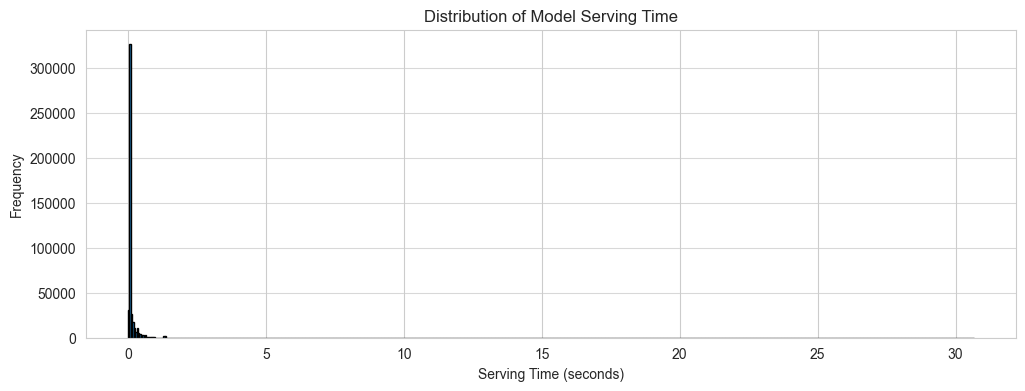

In [2]:

# Convert appropriate columns to numeric types
df['clock'] = df['clock'].astype(float)
df['id'] = df['id'].astype(int)
df['machine id'] = df['machine id'].astype(int)

# Sort the DataFrame by core ID and clock time
df = df.sort_values(['machine id', 'id', 'clock']).reset_index(drop=True)

# Initialize a dictionary to keep track of serving intervals
serving_intervals = {}

# Process each core separately to calculate model serving times
for machined_id, core_id in df[['machine id', 'id']].drop_duplicates().values:
    core_data = df[(df['id'] == core_id) & (df['machine id'] == machined_id)].reset_index(drop=True)
    serving = False
    start_time = None
    serving_times = []

    for idx, row in core_data.iterrows():
        model = row['task']
        clock = row['clock']

        if not serving and pd.notnull(model):
            # Start of serving
            serving = True
            start_time = clock
        elif serving and pd.isnull(model):
            # End of serving
            end_time = clock
            duration = end_time - start_time
            serving_times.append(duration)
            serving = False

    # Store the serving times for the core
    if machined_id not in serving_intervals:
        serving_intervals[machined_id] = {}
    serving_intervals[machined_id][core_id] = serving_times
    #serving_intervals[core_id] = serving_times

# Collect all serving times across cores
#all_serving_times = [time for times in serving_intervals.values() for time in times]
all_serving_times = []
for machine_id, cores in serving_intervals.items():
    for core_id, times in cores.items():
        all_serving_times.extend(times)

# Plot the distribution of model serving times
plt.figure(figsize=(12, 4))
plt.hist(all_serving_times, bins=600, edgecolor='black')
plt.title('Distribution of Model Serving Time')
plt.xlabel('Serving Time (seconds)')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()

In [3]:

# Initialize a dictionary to keep track of C-state residencies
c_state_residency = {}

# Process each core separately to calculate C-state residencies
for machined_id, core_id in df[['machine id', 'id']].drop_duplicates().values:
    core_data = df[(df['id'] == core_id) & (df['machine id'] == machined_id)].reset_index(drop=True)
    c_state_times = {}
    previous_time = None
    previous_c_state = None

    for idx, row in core_data.iterrows():
        clock = row['clock']
        c_state = row['c_state']

        if previous_time is not None:
            duration = clock - previous_time
            c_state_times[previous_c_state] = c_state_times.get(previous_c_state, 0) + duration

        previous_time = clock
        previous_c_state = c_state

    if machined_id not in c_state_residency:
        c_state_residency[machined_id] = {}
    c_state_residency[machined_id][core_id] = c_state_times


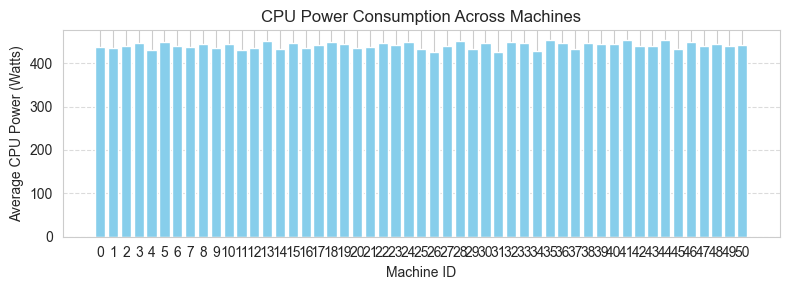

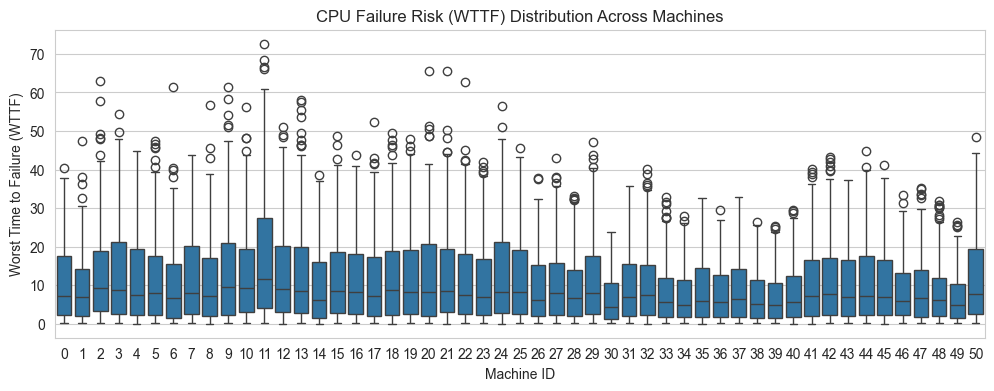

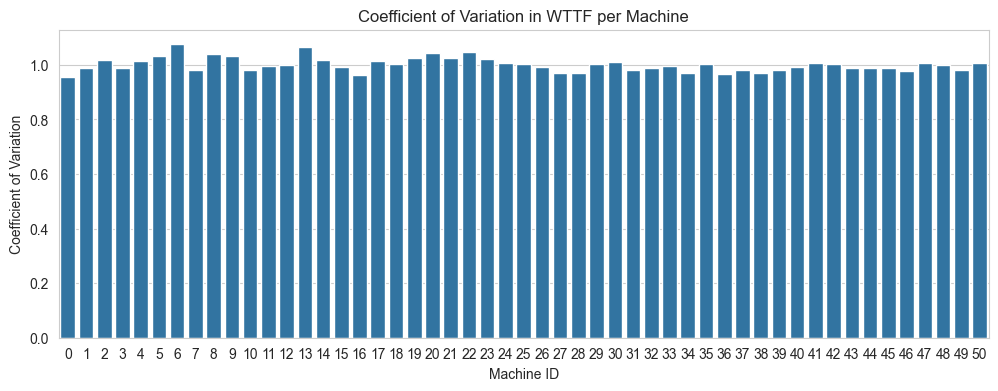

In [4]:
from core_power import calculate_WTTF, get_c_states
import seaborn as sns


def investigate_uneveness_of_c_states_residency(c_state_residency):
    # Your nested dictionary data
    data = c_state_residency
    
    # Convert the nested dictionary into a pandas DataFrame
    records = []
    for machine_id, cores in data.items():
        for core_id, c_states in cores.items():
            record = {'Machine_ID': machine_id, 'Core_ID': core_id}
            record.update(c_states)
            
            c_states_meta = get_c_states()
            pkg_overhead_pw_per_core = list(filter(lambda x: x['state'] == 'package', c_states_meta))[0]['package_overhead_per_core']
            
            total_energy = 0.0
            total_time_s = 0.0
            for c_state, time_spent_s in c_states.items():
                c_state_meta = list(filter(lambda x: x['state'] == c_state, c_states_meta))[0]
                power_w = c_state_meta['power_w'] + pkg_overhead_pw_per_core
                energy_consumed_j = time_spent_s * power_w
                total_energy += energy_consumed_j
                total_time_s += time_spent_s
            record['cpu_energy_j'] = total_energy
            record['cpu_power_w'] = total_energy / total_time_s
            
            records.append(record)
    
    df = pd.DataFrame(records)
    
    # Group by 'Machine_ID' and sum 'cpu_energy_j'
    df_grouped = df.groupby('Machine_ID')['cpu_power_w'].sum().reset_index()
    
    # Plotting
    plt.figure(figsize=(8, 3))
    plt.bar(df_grouped['Machine_ID'], df_grouped['cpu_power_w'], color='skyblue')
    plt.xlabel('Machine ID')
    plt.ylabel('Average CPU Power (Watts)')
    plt.title('CPU Power Consumption Across Machines')
    plt.xticks(df_grouped['Machine_ID'])  # Ensure all Machine_IDs are shown
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
    
    # Melt the DataFrame to have C-states in a single column
    df_melted = df.melt(id_vars=['Machine_ID', 'Core_ID'], value_vars=['C0', 'C1', 'C6'],
                        var_name='C_State', value_name='Time_Spent')
    
    # Calculate WTTF for each core and C-state
    df_melted['WTTF'] = df_melted.apply(lambda row: calculate_WTTF(row['Time_Spent'], row['C_State']), axis=1)

    # Summarize WTTF per core
    wttf_per_core = df_melted.groupby(['Machine_ID', 'Core_ID'])['WTTF'].sum().reset_index()
    
    
    # Visualize CPU failure risk for the first machine
    def visualize_failure_risk(machine_id):
        machine_data = wttf_per_core[wttf_per_core['Machine_ID'] == machine_id]
        
        # Plot WTTF per core
        plt.figure(figsize=(8, 2))
        sns.barplot(x='Core_ID', y='WTTF', data=machine_data)
        plt.title(f'Machine {machine_id}: CPU Failure Risk (WTTF) per Core')
        plt.xlabel('Core ID')
        plt.ylabel('Worst Time to Failure (WTTF)')
        plt.show()
        
        # Calculate unevenness across cores
        wttf_values = machine_data['WTTF']
        cv = wttf_values.std() / wttf_values.mean()
        print(f'Machine {machine_id}: Coefficient of Variation in WTTF across Cores: {cv:.4f}\n')
    
    # Analyze all machines
    # for machine_id in sorted(wttf_per_core['Machine_ID'].unique()):
    #     visualize_failure_risk(machine_id)
    
    # Visualize CPU failure risk across the entire machine fleet
    plt.figure(figsize=(12, 4))
    sns.boxplot(x='Machine_ID', y='WTTF', data=wttf_per_core)
    plt.title('CPU Failure Risk (WTTF) Distribution Across Machines')
    plt.xlabel('Machine ID')
    plt.ylabel('Worst Time to Failure (WTTF)')
    plt.show()
    
    # Collect CVs for all machines
    cv_records = []
    for machine_id in sorted(wttf_per_core['Machine_ID'].unique()):
        machine_data = wttf_per_core[wttf_per_core['Machine_ID'] == machine_id]
        wttf_values = machine_data['WTTF']
        cv = wttf_values.std() / wttf_values.mean()
        cv_records.append({'Machine_ID': machine_id, 'CV': cv})
    
    cv_df = pd.DataFrame(cv_records)
    
    # Plot CVs per Machine
    plt.figure(figsize=(12, 4))
    sns.barplot(x='Machine_ID', y='CV', data=cv_df)
    plt.title('Coefficient of Variation in WTTF per Machine')
    plt.xlabel('Machine ID')
    plt.ylabel('Coefficient of Variation')
    plt.show()
    
investigate_uneveness_of_c_states_residency(c_state_residency=c_state_residency)

Application characteristics of the system.

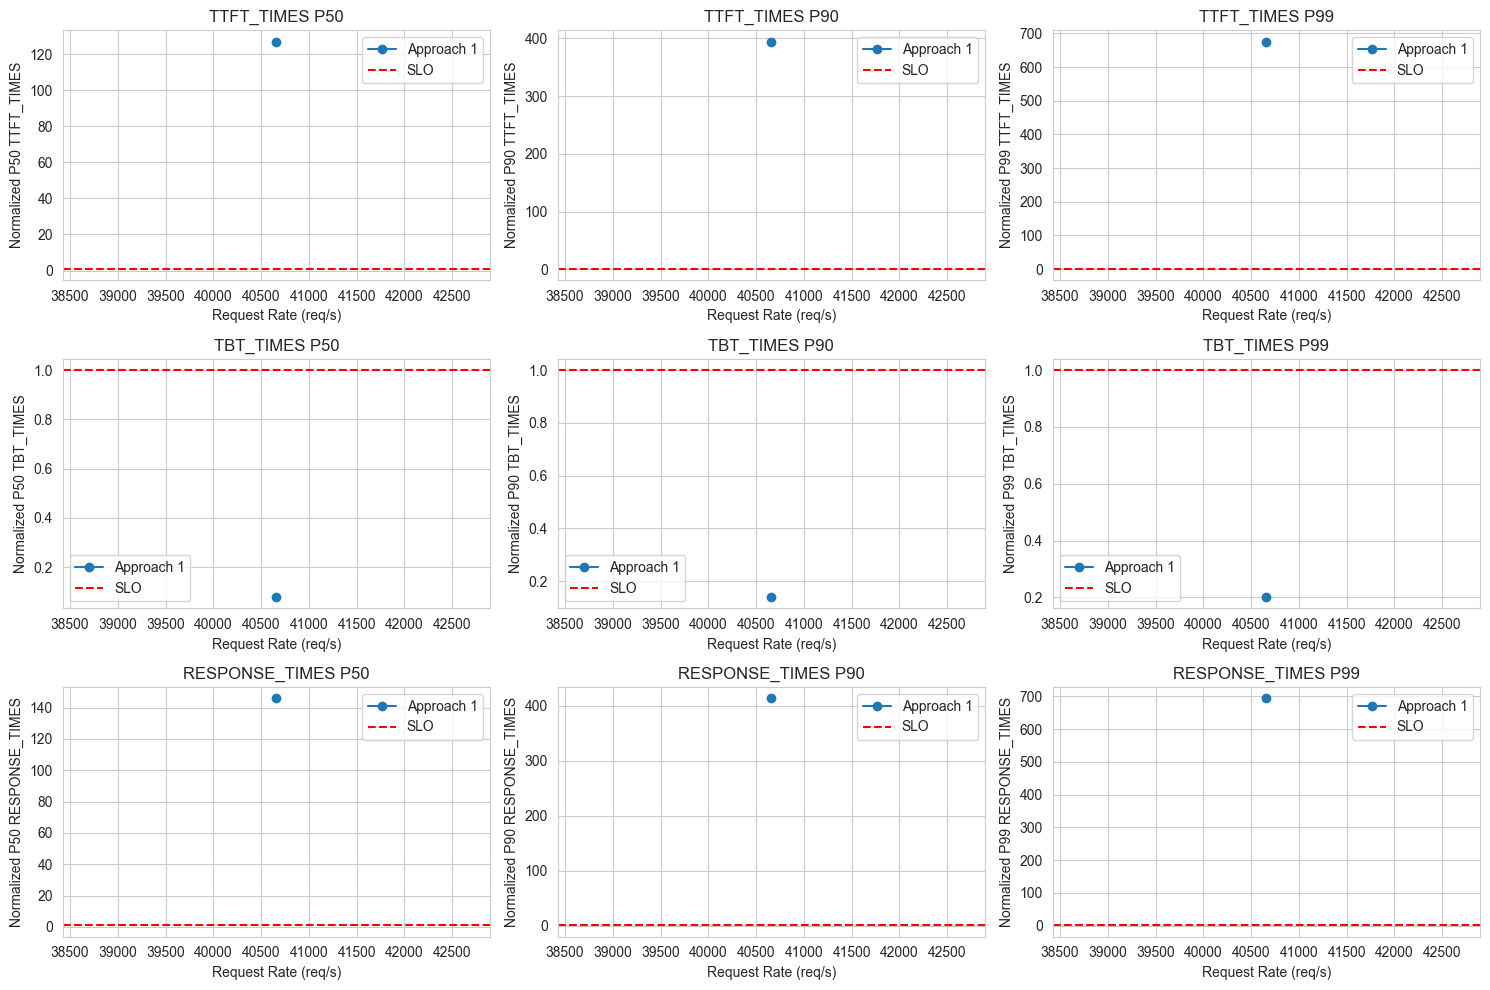

In [5]:
# import pandas as pd
# import matplotlib.pyplot as plt
# import seaborn as sns

def analyze_application_aspect():
    # Read the CSV data into a pandas DataFrame
    data = pd.read_csv(experiment + "summary.csv")
    
    # Define columns for different percentiles and metrics
    metrics = ['ttft_times', 'tbt_times', 'response_times']  # Add other metrics if needed
    percentiles = ['p50', 'p90', 'p99']
    request_rate_column = 'request_ids_mean'  # Use this column as the x-axis (request rate)
    
    # Plot settings
    fig, axes = plt.subplots(len(metrics), len(percentiles), figsize=(15, 10))
    fig.subplots_adjust(hspace=0.5, wspace=0.5)
    
    # Loop over each metric and percentile to create subplots
    for i, metric in enumerate(metrics):
        for j, percentile in enumerate(percentiles):
            ax = axes[i, j]
            y_column = f"{metric}_{percentile}"  # Construct column name like 'ttft_times_p50'
            
            # Plot data for the single approach
            ax.plot(data[request_rate_column], data[y_column], marker='o', label='Approach 1')
            
            # Customize plot
            ax.set_xlabel('Request Rate (req/s)')
            ax.set_ylabel(f'Normalized {percentile.upper()} {metric.upper()}')
            ax.axhline(y=1, color='red', linestyle='--', label='SLO')  # SLO line
            ax.legend()
            ax.grid(True)
    
            # Set title for clarity
            ax.set_title(f'{metric.upper()} {percentile.upper()}')
    
    plt.tight_layout()
    plt.show()

analyze_application_aspect()